In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir /content/drive/MyDrive/Cloth/dataset

In [2]:
# !unzip /content/drive/MyDrive/Cloth/JPEG_Dataset.zip -d /content/drive/MyDrive/Cloth/dataset

In [3]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [54]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((64, 64))


# Path to the dataset folder
root_dir = '/content/drive/MyDrive/Cloth/dataset/'

train_dir = os.path.join(root_dir)


In [55]:
classes = os.listdir(root_dir)

In [56]:
classes

['Jackets', 'Pants', 'Tops', 'Track Pants', 'Tshirts']

In [57]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [58]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpeg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")




[INFO] Loading images ...
[INFO] Processing Jackets ...
[INFO] Processing Pants ...
[INFO] Processing Tops ...
[INFO] Processing Track Pants ...
[INFO] Processing Tshirts ...
[INFO] Image loading completed

Total number of images: 142


In [59]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('vgg_model_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  5


In [60]:
# image_labels

In [61]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [62]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


In [63]:
# x_train = np.asarray(x_train,np.float32)/255
# x_test  = np.asarray(x_test,np.float32) /255
# y_train = np.asarray(y_train)
# y_test  = np.asarray(y_test)

In [64]:
print('Train Images shape is   : ',x_train.shape)
print('Train  Labels  shape is : ',y_train.shape)

Train Images shape is   :  (113, 64, 64, 3)
Train  Labels  shape is :  (113, 5)


In [65]:
batch_size = 128
#create image generator for images 
image_gen = ImageDataGenerator(
                                  shear_range = 0.2,
                                  zoom_range = 0.3,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                   horizontal_flip=True,
                                   rotation_range = 20, 
                            
                               )

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(  
                                  shear_range = 0.2,
                                  zoom_range = 0.3,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                   horizontal_flip=True,
                                   rotation_range = 20,)
        
train = image_gen.flow(
      x_train,
      y_train,
      shuffle=True, 
      batch_size=batch_size
      )
test = test_data_gen.flow(
      x_test,
      y_test,
      shuffle=True, 
      batch_size=batch_size
      )

In [66]:
import tensorflow as tf

vgg16net = tf.keras.applications.VGG16(
  include_top=False,
  input_shape=(64,64,3),
  weights='imagenet')

In [67]:
vgg_model = tf.keras.models.Sequential([
  tf.keras.Model(inputs=vgg16net.input, outputs=vgg16net.get_layer('block3_pool').output, name="vgg16"),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5, activation='sigmoid')                        
])
vgg_model.get_layer("vgg16").trainable=False
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 256)         1735488   
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               8389120   
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 10,289,477
Trainable params: 8,553,989
N

In [68]:
vgg_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [69]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                   mode='max',
                                   patience=20,
                                   restore_best_weights=True),
  tf.keras.callbacks.ModelCheckpoint('models/vgg.h5',
                                     monitor='val_accuracy',
                                     mode='max',
                                    save_best_only=True)]

In [74]:
# Training model
n_training_samples = len(train)
n_validation_samples = len(test)
history = vgg_model.fit(
    train,
    epochs=200,
    validation_data=test,
    validation_steps=n_validation_samples//batch_size,
    batch_size=128,
    shuffle = True,
    callbacks = callbacks,
    )


Epoch 1/200
1/1 [==============================] - 0s 360ms/step - loss: 0.6805 - accuracy: 0.6018
Epoch 2/200
1/1 [==============================] - 0s 290ms/step - loss: 0.4703 - accuracy: 0.6637
Epoch 3/200
1/1 [==============================] - 0s 296ms/step - loss: 0.3574 - accuracy: 0.6460
Epoch 4/200
1/1 [==============================] - 0s 297ms/step - loss: 0.5266 - accuracy: 0.5664
Epoch 5/200
1/1 [==============================] - 0s 296ms/step - loss: 0.5696 - accuracy: 0.5841
Epoch 6/200
1/1 [==============================] - 0s 298ms/step - loss: 0.6635 - accuracy: 0.5310
Epoch 7/200
1/1 [==============================] - 0s 296ms/step - loss: 0.6833 - accuracy: 0.6283
Epoch 8/200
1/1 [==============================] - 0s 300ms/step - loss: 0.7105 - accuracy: 0.5133
Epoch 9/200
1/1 [==============================] - 0s 293ms/step - loss: 0.8210 - accuracy: 0.6195
Epoch 10/200
1/1 [==============================] - 0s 292ms/step - loss: 0.5630 - accuracy: 0.5310
Epoch 11/

In [ ]:
# history = vgg_model.fit(
#     train,
#     epochs=1,
#     validation_data=test,
#     validation_steps=n_validation_samples//batch_size,
#     batch_size=128,
#     shuffle = True,
#     callbacks = callbacks,
#     )

4/4 [==============================] - 3s 698ms/step - loss: 3.3891 - accuracy: 0.7345


In [75]:
score, acc = vgg_model.evaluate(test,batch_size=batch_size)                       
print('Test accuracy:', acc)

1/1 [==============================] - 0s 105ms/step - loss: 0.7394 - accuracy: 0.4483
Test accuracy: 0.4482758641242981


In [ ]:
vgg_model.save('vgg.h5')

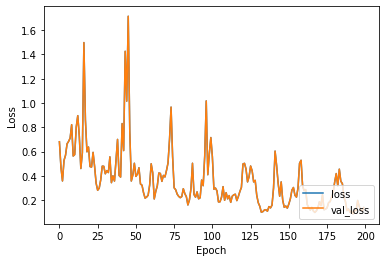

In [76]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [80]:
# Serialize model to JSON
model_json = vgg_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5
vgg_model.save_weights("model_weight.h5")
vgg_model.save('model.h5')

In [79]:
def predict_img(file_path):
  image = cv2.imread(file_path)
  image = cv2.resize(image, DEFAULT_IMAGE_SIZE)  
  plt.imshow(image)
  plt.show()

  image = img_to_array(image) 
  np_image_list = np.array([image], dtype=np.float16) / 225.0




  preds = vgg_model.predict(np_image_list,batch_size=None, verbose=0)
  labels = np.argmax(preds, axis=-1)
  print(labels)    
  print("\nPREDICTION : "+classes[labels[0]])

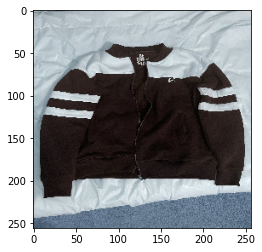

[0]

PREDICTION : Jackets


In [46]:
predict_img('test.jpeg')

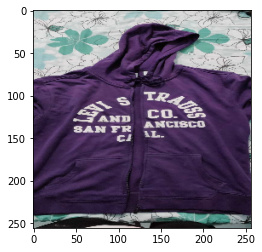

[4]

PREDICTION : Tshirts


In [47]:
predict_img('test1.jpeg')

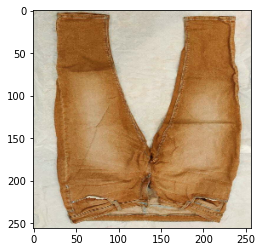

[1]

PREDICTION : Pants


In [49]:
predict_img('test3.jpeg')

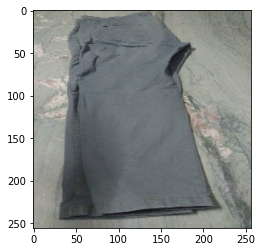

[3]

PREDICTION : Track Pants


In [50]:
predict_img('test4.jpeg')

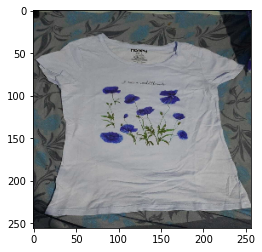

[4]

PREDICTION : Tshirts


In [51]:
predict_img('test5.jpeg')

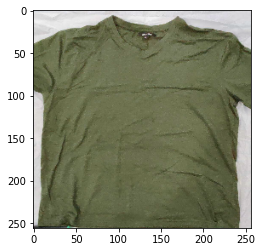

[4]

PREDICTION : Tshirts


In [52]:
predict_img('test6.jpeg')